# Pre-req

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/sharoz/Downloads/human_ds


In [2]:
# !pip freeze > requirements.txt

In [3]:
import torch

In [4]:
print("Is CUDA enabled?",torch.cuda.is_available())

Is CUDA enabled? True


In [5]:
%cd {HOME}
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
# !git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
# !pip install -q -e .

/home/sharoz/Downloads/human_ds
/home/sharoz/Downloads/human_ds/GroundingDINO


In [6]:
%cd {HOME}

import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/home/sharoz/Downloads/human_ds


In [7]:
# !pip uninstall -y supervision
# !pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

0.16.0


/home/sharoz/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# !pip install -q roboflow

In [9]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/home/sharoz/Downloads/human_ds/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [10]:
%cd {HOME}
# !mkdir -p {HOME}/weights
%cd {HOME}/weights

# !wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/home/sharoz/Downloads/human_ds
/home/sharoz/Downloads/human_ds/weights


In [11]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/home/sharoz/Downloads/human_ds/weights/groundingdino_swint_ogc.pth ; exist: True


In [12]:
%cd {HOME}
# !mkdir -p {HOME}/weights
%cd {HOME}/weights

# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/home/sharoz/Downloads/human_ds
/home/sharoz/Downloads/human_ds/weights


In [13]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/home/sharoz/Downloads/human_ds/weights/sam_vit_h_4b8939.pth ; exist: True


# load Models

## Load models

In [14]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [15]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/home/sharoz/Downloads/human_ds/GroundingDINO


/home/sharoz/Downloads/human_ds/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/home/sharoz/anaconda3/envs/gsam/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


### Load Segment Anything Model (SAM)

In [16]:
SAM_ENCODER_VERSION = "vit_h"

In [17]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Full Ds Flow

## Full Dataset Mask Auto Annotation

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# import shutil
# shutil.copy2("/content/drive/MyDrive/full_human_ds.zip", "/content/data/full_human_ds.zip")
# !unzip /content/data/full_human_ds.zip -d /content/data


In [20]:
from glob import glob
print(len(glob("/home/sharoz/Downloads/human_ds/images/*")))

19575


In [21]:
import os

IMAGES_DIRECTORY = os.path.join(HOME, 'images')
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png']

# CLASSES = ['car', 'dog', 'person', 'nose', 'chair', 'shoe', 'ear', 'coffee', 'backpack', 'cap']
CLASSES = ['arm', "leg", "head", "hand"]
# CLASSES = ['shirt']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

### Extract labels from images

In [22]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [23]:
def create_equal_slices(input_list, num_slices=10):
    slice_size = len(input_list) // num_slices
    remainder = len(input_list) % num_slices

    slices = []
    start = 0

    for i in range(num_slices):
        end = start + slice_size + (1 if i < remainder else 0)
        slices.append(input_list[start:end])
        start = end

    return slices

# # Example usage:
# my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# slices = create_equal_slices(my_list, num_slices=10)

# # Create a list of lists
# list_of_lists = [slice_list for slice_list in slices]

# print(list_of_lists)

In [24]:
import cv2
from tqdm.notebook import tqdm

# images = {}
# annotations = {}

image_paths = sv.list_files_with_extensions(
    directory=IMAGES_DIRECTORY,
    extensions=IMAGES_EXTENSIONS)

slices = create_equal_slices(image_paths, num_slices=15)

for idx, instance in tqdm(enumerate(slices)):
  images = {}
  annotations = {}
  for image_path in tqdm(instance):

      image_name = image_path.name
      image_path = str(image_path)
      image = cv2.imread(image_path)

      detections = grounding_dino_model.predict_with_classes(
          image=image,
          classes=enhance_class_name(class_names=CLASSES),
          box_threshold=BOX_TRESHOLD,
          text_threshold=TEXT_TRESHOLD
      )
      detections = detections[detections.class_id != None]
      detections.mask = segment(
          sam_predictor=sam_predictor,
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
          xyxy=detections.xyxy
      )
      images[image_name] = image
      annotations[image_name] = detections


  ANNOTATIONS_DIRECTORY = os.path.join(HOME, f'annotations/{idx}')

  MIN_IMAGE_AREA_PERCENTAGE = 0.002
  MAX_IMAGE_AREA_PERCENTAGE = 0.80
  APPROXIMATION_PERCENTAGE = 0.75
  sv.Dataset(
      classes=CLASSES,
      images=images,
      annotations=annotations
  ).as_pascal_voc(
      annotations_directory_path=ANNOTATIONS_DIRECTORY,
      min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
      max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
      approximation_percentage=APPROXIMATION_PERCENTAGE
  )

0it [00:00, ?it/s]

  0%|          | 0/1305 [00:00<?, ?it/s]

/home/sharoz/anaconda3/envs/gsam/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sharoz/anaconda3/envs/gsam/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sharoz/anaconda3/envs/gsam/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


NameError: name '_C' is not defined

In [13]:
!pip install torch -f https://download.pytorch.org/whl/torch_stable.html --upgrade


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 GB 2.5 MB/s eta 0:08:57^C
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 GB 2.5 MB/s eta 0:08:57
ERROR: Operation cancelled by user


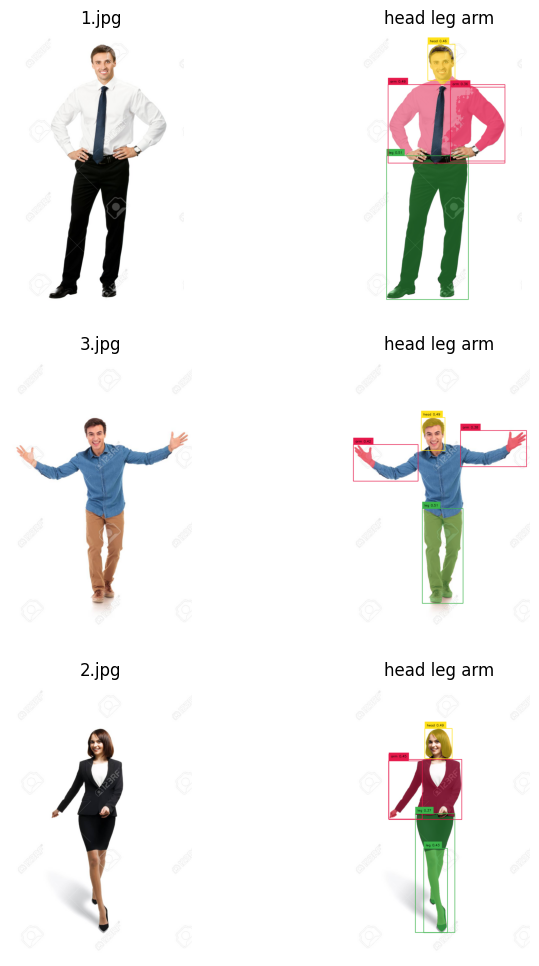

In [ ]:
plot_images = []
plot_titles = []

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

for image_name, detections in annotations.items():
    image = images[image_name]
    plot_images.append(image)
    plot_titles.append(image_name)

    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    plot_images.append(annotated_image)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]))
    plot_titles.append(title)

sv.plot_images_grid(
    images=plot_images,
    titles=plot_titles,
    grid_size=(len(annotations), 2),
    size=(2 * 4, len(annotations) * 4)
)

### Save labels in Pascal VOC XML


In [ ]:
ANNOTATIONS_DIRECTORY = os.path.join(HOME, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75


In [ ]:
sv.Dataset(
    classes=CLASSES,
    images=images,
    annotations=annotations
).as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)